In [2]:
import star_functions as nana

/Users/nana/venv/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [3]:
import importlib
importlib.reload(nana)

<module 'star_functions' from '/Users/nana/venv/hoggnation/oscillator_catalog/star_functions.py'>

In [4]:
%reload_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import numpy as np
from astropy import units as u

In [9]:
star_files = glob.glob("*.dat")

In [10]:
print(star_files)
#kplr010536147

['kplr005309849_pixeldata_manualdetrended.dat', 'kplr004939281_pixeldata_manualdetrended.dat', 'kplr003865742.dat', 'kplr004930889.dat', 'kplr010526294.dat', 'kplr005941844_pixeldata_manualdetrended.dat', 'kplr006462033_pixeldata_manualdetrended.dat', 'kplr011971405_pixeldata_tilloutburst.dat', 'kplr007760680_pixeldata_filtered_manualdetrended.dat', 'kplr009020774.dat', 'kplr006352430.dat', 'kplr010536147.dat', 'kplr008459899.dat', 'kplr003459297.dat', 'kplr008714886.dat', 'kplr003240411.dat', 'kplr008057661.dat', 'kplr012258330.dat', 'kplr011360704.dat', 'kplr008255796_pixeldata_manualdetrended.dat', 'kplr008766405.dat', 'kplr004936089_pixeldata_manualdetrended.dat', 'kplr006780397_pixeldata_manualdetrended.dat', 'kplr007630417_pixeldata_manualdetrended.dat', 'kplr009715425_pixeldata_manualdetrended_full_v2.dat', 'kplr008381949.dat']


In [11]:
def do_one_star(star_fn, exptime = 'long'):
    
    star = star_fn[:13] #brittle

    print("working on ", star)
    
    #pipeline 
    lc, delta_f, sampling_time, exptime = nana.star(star, exptime = exptime)
    print("delta_f:", delta_f)
    print("sampling_time:", sampling_time)
    if lc is None:
        return 
    f_max = (3 / (2*sampling_time))
    f_min = delta_f/3
    t_fit, flux_fit, weight_fit = nana.mask_vals(lc)
    freq_full, power_full = nana.pg_full(f_min, f_max, lc)
    freq_mini, power_mini = nana.pg_mini(f_min, f_max, lc )
    indices = nana.get_filtered_peaks(12, freq_mini, power_mini)
    refined_freq, refined_power, second_derivatives = nana.refine_peaks(freq_mini, power_mini, indices)
    fc = nana.folding_freq(delta_f, freq_full, power_full, sampling_time, False)
    regions, final_freqs, chi2s = nana.region_and_freq(indices, fc, f_min, freq_mini, power_mini, t_fit, flux_fit, weight_fit, exptime)
    '''
    plt.plot(freq_full, power_full, 'k.')
    plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
    plt.show()
    
    plt.plot(freq_mini, power_mini, 'g-')
    plt.semilogy()
    plt.show()
    '''
    a_early, a_late, b_early, b_late = nana.check_coherence(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    rate_of_phase, rate_of_amp = nana.change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit)
    delta_chi2s = nana.null_chi_squared(flux_fit, weight_fit) - chi2s
    sharpnesses = nana.sharpness(second_derivatives, refined_power)
    
    '''
    data = Table()


    data['modes'] = final_freqs
    data['regions'] = regions
    data['corresponding_freq_in_region_A'] = refined_freq
    data['sharpness'] = sharpnesses
    data['delta_chi_squares'] = delta_chi2s
    data['rate_of_change_of_phase'] = rate_of_phase
    data['rate_of_change_of_amplitude'] = rate_of_amp
    
    ascii.write(
        data,
        star + '.csv',
        overwrite=True,
        format="csv",
        formats={
            "modes": "{:.10f}",
            "corresponding_freq_in_region_A": "{:.5f}",
            "sharpness": "{:.7e}",
            "delta_chi_squares": "{:.7e}",
            "rate_of_change_of_phase": "{:.7e}",
            "rate_of_change_of_amplitude": "{:.7e}"
        }
    )
    '''

    return
    

In [12]:
##out of spec stars
#kplr006462033
#kplr010536147
#kplr008459899
#kplr003459297
#kplr003240411
#kplr012258330
#

In [13]:
#out of spec stars
#kplr006462033
#kplr010536147
#kplr008459899
#kplr003240411
#kplr012258330
#kplr008766405

In [14]:
def check_coherence2(ts, ys, weights, oms, T):

    Qs = [[[ ] , [ ]] for i in range(4)]

    ts_median = np.median(ts)
    t_first = np.median(ts[ts < ts_median])
    t_third = np.median(ts[ts >= ts_median])

    mask_q1 = (ts < ts_median) & (ts < t_first)
    mask_q2 = (ts < ts_median) & (ts >= t_first)
    mask_q3 = (ts >= ts_median) & (ts < t_third)
    mask_q4 = (ts >= ts_median) & (ts >= t_third)

    cases = [mask_q1, mask_q2, mask_q3, mask_q4]
    
    for om in oms:
        for q, I in zip(Qs, cases):
            A = nana.integral_design_matrix(ts[I], om, T)
            pars, _ =nana.weighted_least_squares_new(A, ys[I], weights[I])
            q[0].append(pars[1])
            q[1].append(pars[2])

    return Qs[0], Qs[1], Qs[2], Qs[3]
            



delta_f: 0.0006851713750877364
sampling_time: 0.02043362654512748


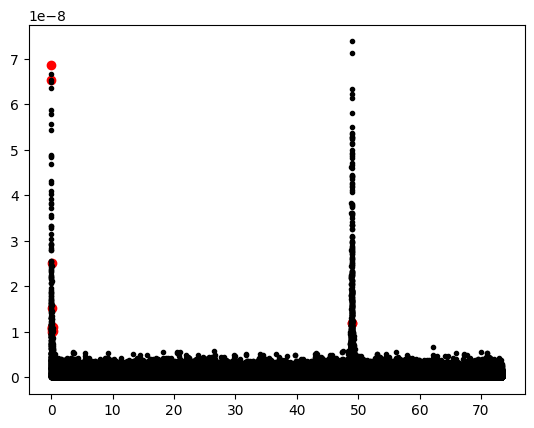

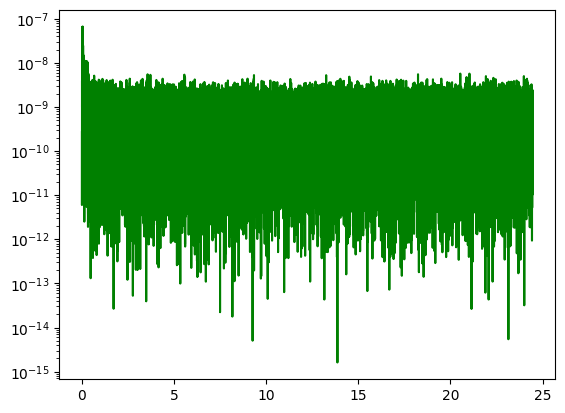

In [15]:
#og KIC 520 star star
lc, delta_f, sampling_time, exptime520 = nana.star('KIC 003336252')
print("delta_f:", delta_f)
print("sampling_time:", sampling_time)
#if lc is None:
    #return 
f_max = (3 / (2*sampling_time))
f_min = delta_f/3
t_fit520, flux_fit520, weight_fit520 = nana.mask_vals(lc)
freq_full, power_full = nana.pg_full(f_min, f_max, lc)
freq_mini, power_mini = nana.pg_mini(f_min, f_max, lc )
indices = nana.get_filtered_peaks(12, freq_mini, power_mini)
refined_freq, refined_power, second_derivatives = nana.refine_peaks(freq_mini, power_mini, indices)
fc = nana.folding_freq(delta_f, freq_full, power_full, sampling_time, False)
regions, final_freqs520, chi2s = nana.region_and_freq(indices, fc, f_min, freq_mini, power_mini, t_fit520, flux_fit520, weight_fit520, exptime520)

plt.plot(freq_full, power_full, 'k.')
plt.scatter(final_freqs520, refined_power, color = 'red', marker = 'o')
plt.show()

plt.plot(freq_mini, power_mini, 'g-')
plt.semilogy()
plt.show()

a_early, a_late, b_early, b_late = nana.check_coherence(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)
rate_of_phase, rate_of_amp = nana.change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit520)
delta_chi2s = nana.null_chi_squared(flux_fit520, weight_fit520) - chi2s
sharpnesses = nana.sharpness(second_derivatives, refined_power)

delta_f: 0.0006800582572566702
sampling_time: 0.02043360086827306


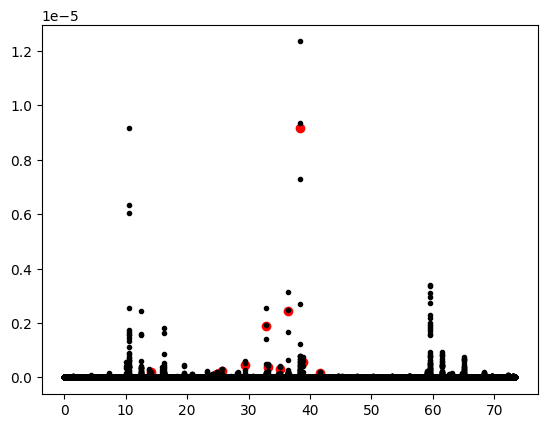

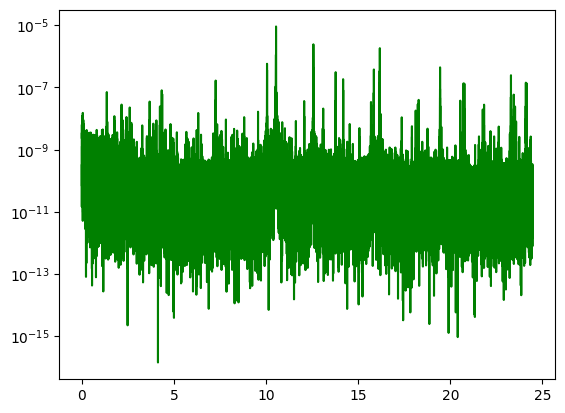

In [7]:
#og KIC 520 star star
lc, delta_f, sampling_time, exptime520 = nana.star('KIC 5202905')
print("delta_f:", delta_f)
print("sampling_time:", sampling_time)
#if lc is None:
    #return 
f_max = (3 / (2*sampling_time))
f_min = delta_f/3
t_fit520, flux_fit520, weight_fit520 = nana.mask_vals(lc)
freq_full, power_full = nana.pg_full(f_min, f_max, lc)
freq_mini, power_mini = nana.pg_mini(f_min, f_max, lc )
indices = nana.get_filtered_peaks(12, freq_mini, power_mini)
refined_freq, refined_power, second_derivatives = nana.refine_peaks(freq_mini, power_mini, indices)
fc = nana.folding_freq(delta_f, freq_full, power_full, sampling_time, False)
regions, final_freqs520, chi2s = nana.region_and_freq(indices, fc, f_min, freq_mini, power_mini, t_fit520, flux_fit520, weight_fit520, exptime520)

plt.plot(freq_full, power_full, 'k.')
plt.scatter(final_freqs520, refined_power, color = 'red', marker = 'o')
plt.show()

plt.plot(freq_mini, power_mini, 'g-')
plt.semilogy()
plt.show()

a_early, a_late, b_early, b_late = nana.check_coherence(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)
rate_of_phase, rate_of_amp = nana.change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit520)
delta_chi2s = nana.null_chi_squared(flux_fit520, weight_fit520) - chi2s
sharpnesses = nana.sharpness(second_derivatives, refined_power)

In [8]:
import matplotlib.ticker as ticker

In [9]:
def splitting(ts, K, jackknife = True):
    '''
    # splitting()
    Produce either disjoint or jackknife subsamples.
    
    ## Inputs:
    - `ts`: shape `(N, )` array of times (not necesarily ordered)
    - `K`: number of subsamples to return
    - `jackknife`: `True` for jackknife subsamples; otherwise disjoint
    
    ## Output: 
    - `masks`: shape `(K, N)` boolean array; `True` if in subsample

    ## Comment:
    - Relies on numpy conventions about relationships between integers and bools.
    '''
    N = len(ts)
    indices = np.argsort(ts)
    split_indices = np.array_split(indices, K)
    if jackknife:
        masks = np.ones((K, N), dtype=bool) # make everything True by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = False # remove subsample
    else:
        masks = np.zeros((K, N), dtype=bool) # make everything False by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = True # add subsample
    return masks

In [12]:
###FINAL COHERENCE TEST!!!!
def coherence_all(ts, ys, weights, final_freq, T):
    oms = np.array([f * 2 * np.pi for f in final_freq])
    all = np.zeros((len(oms), 2))

    for idx, om in enumerate(oms):
        A = nana.integral_design_matrix(ts, om, T)
        pars, _ = nana.weighted_least_squares_new(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]
        

    splits = np.array([2, 4, 8])
    results = [np.zeros((len(oms), n, 2)) for n in splits]
    
    for split, result in zip(splits, results):     

        jack = (split == 8)
        masks = splitting(ts, split, jackknife = jack)
        for idx, om in enumerate(oms):
            for i, mask in enumerate(masks):
                A = nana.integral_design_matrix(ts[mask], om, T)
                pars, _ = nana.weighted_least_squares_new(A, ys[mask], weights[mask])
                result[idx][i][0] = pars[1] #a
                result[idx][i][1] = pars[2] #b

    return all, results[0], results[1], results[2] #all, half, quarter, eighth (+jacknives)
    

In [13]:
all, half, quartiles, eighths = coherence_all(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)

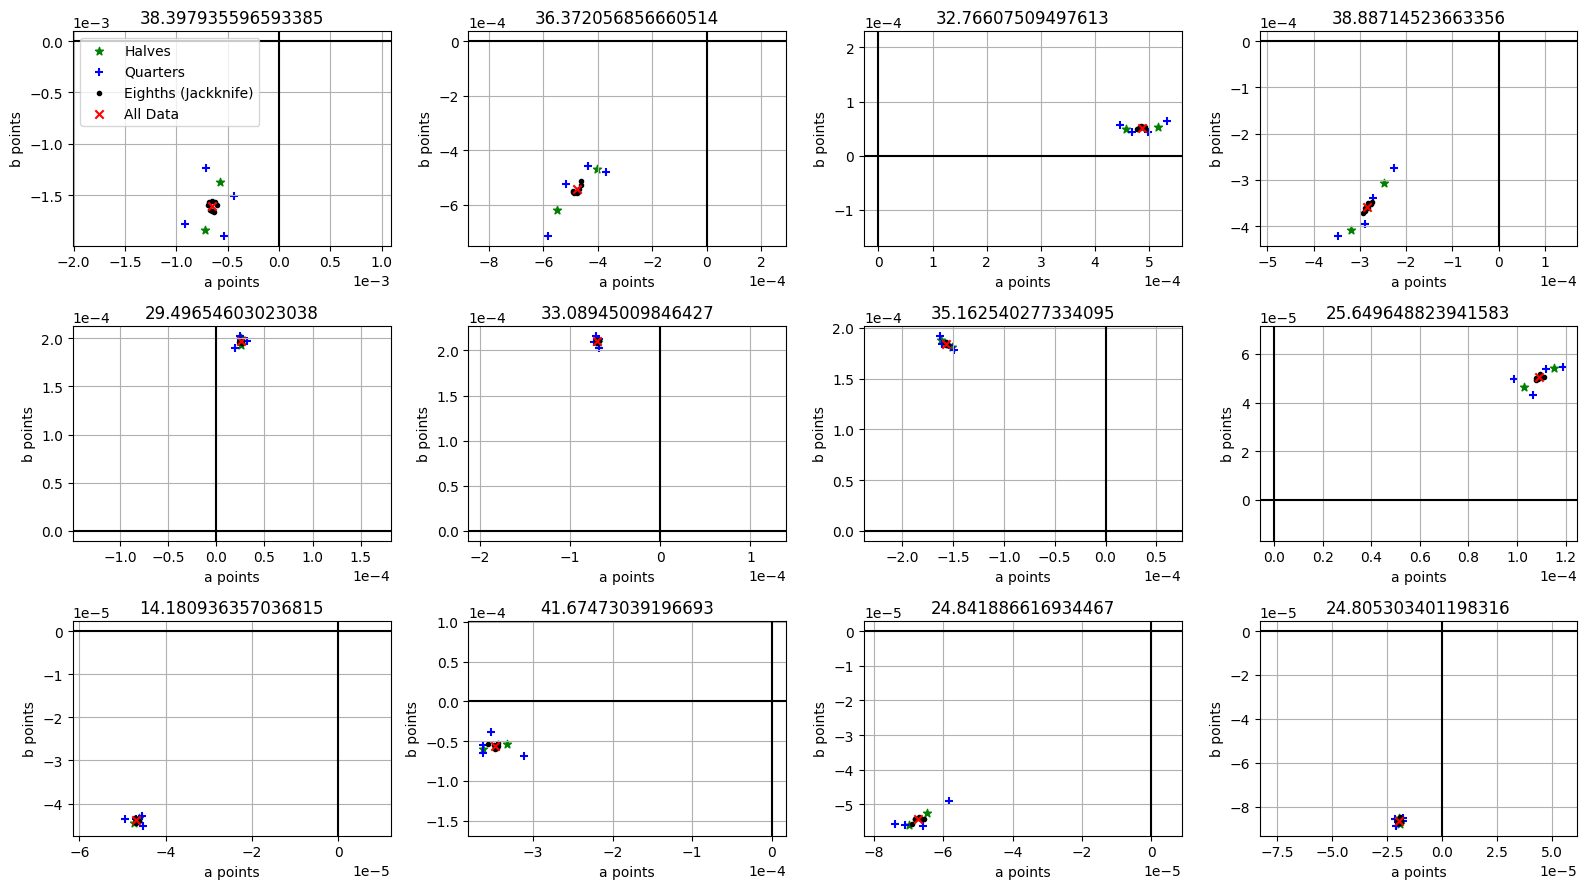

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

for idx, (ax, points1, points2, points3, points4) in enumerate(zip(axes.flat, all, half, quartiles, eighths)):
    a_all = points1[0]  
    b_all = points1[1]  

    a_half = points2[:, 0]  
    b_half = points2[:, 1]  

    a_quarter = points3[:, 0]  
    b_quarter = points3[:, 1] 

    a_eighth = points4[:, 0]
    b_eighth= points4[:, 1]

    ax.scatter(a_half, b_half, color='green', marker='*', label='Halves')
    ax.scatter(a_quarter, b_quarter, color='blue', marker='+', label='Quarters')
    ax.scatter(a_eighth, b_eighth, color='k', marker='.', label='Eighths (Jackknife)')
    ax.scatter(a_all, b_all, color='red', marker='x', label='All Data')

    if idx == 0:
        ax.legend()
    
    ax.axvline(0, color = 'k')
    ax.axhline(0, color = 'k')
    ax.set_title(final_freqs520[idx])
    ax.set_xlabel("a points")
    ax.set_ylabel("b points")
    ax.grid(True)
    ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
    ax.axis('equal')



plt.tight_layout()


In [15]:
def sampling_stats(alls, quartiles, eighths):

    f_num = len(alls)
    
    amp_change = np.zeros((f_num, 4))
    phase_change = np.zeros((f_num, 4))

    sigma_lnA = np.zeros(f_num)
    sigma_phi4 = np.zeros(f_num)
    sigma_phij = np.zeros(f_num)
    
    for inx, (all, quartile, eighth) in enumerate(zip(alls, quartiles, eighths)):

        deltak_4 = np.zeros((4,2))
        deltak_j = np.zeros((8,2))
        a,b = all[0], all[1]
    
        for i, q in enumerate(quartile):   
            deltak_4[i] = [a - q[0], b - q[1]]

        for i, j in enumerate(eighth):   
            deltak_j[i] = [a - j[0], b - j[1]]
                
        x = np.array([a,b])
        x_norm = np.linalg.norm([a, b])
        x_hat = x / x_norm
        y_hat = [x_hat[1], - x_hat[0]]

        amp = np.dot(deltak_4, x_hat)/ x_norm
        phase4 = np.dot(deltak_4, y_hat)/x_norm
        phasej = np.dot(deltak_j, y_hat)/x_norm

        var_lnA = 0.5 * np.sqrt(np.mean(amp ** 2))#1/2 rms lnA
        varphi4 = 0.5 * np.sqrt(np.mean(phase4 ** 2)) #1/2 rms phase

        varphij = np.sqrt((7/8) * np.sum(phasej ** 2)) #sigma phi

        amp_change[inx] = amp
        phase_change[inx] = phase4

        sigma_lnA[inx] = var_lnA
        sigma_phi4[inx] = varphi4
        sigma_phij[inx] = varphij 
        
        

    return amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij

In [16]:
amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij = sampling_stats(all, quartiles, eighths)
print(f"this is the change in ln(amp){amp_change}")
print(f"this is the change in phase{phase_change}")
print("sigma lnA:", sigma_lnA)
print("sigma phi for quarter:", sigma_phi4)
print("sigma phi for jackknife:", sigma_phij)

this is the change in ln(amp)[[ 0.18195383  0.09983879 -0.13063635 -0.15050353]
 [ 0.16184712  0.12637472 -0.01418846 -0.27488288]
 [ 0.08140746  0.03959995 -0.02319419 -0.09774471]
 [ 0.22186167  0.04771805 -0.07398613 -0.19507244]
 [-0.00461297  0.03858796 -0.00804903 -0.02626477]
 [-0.00931068  0.0006988   0.0343444  -0.02604635]
 [-0.04058119 -0.00876038  0.03958959  0.00952947]
 [ 0.07955638  0.04283686 -0.03368848 -0.08862112]
 [-0.02702026  0.00175068  0.02279096  0.00221245]
 [-0.04109369 -0.04712963 -0.00734289  0.09628305]
 [-0.04689327  0.11770823 -0.00067281 -0.07105894]
 [ 0.01733717  0.00728056 -0.02801969  0.00335004]]
this is the change in phase[[-0.1128142   0.09173757  0.12612977 -0.10735376]
 [ 0.05367265 -0.03652002 -0.0605093   0.0440605 ]
 [ 0.01840104 -0.01296827 -0.01853886  0.01332303]
 [-0.01487156 -0.00415159  0.04156037 -0.02315122]
 [-0.03335257  0.02720987  0.00076603  0.00511117]
 [-0.0132379   0.01509772  0.0008282  -0.00268908]
 [-0.00095395  0.01406661

In [17]:
print("rate of change of phase", rate_of_phase)
print("rate of chnage of log amp", rate_of_amp)

rate of change of phase [-2.64306929e-05  2.19343150e-05  6.83223556e-06 -2.43004225e-05
 -7.65209474e-06  2.41228521e-06  1.69396069e-05 -1.93133023e-05
  1.84690221e-06  6.81410994e-06  9.53841744e-06 -1.33490806e-05]
rate of chnage of log amp [ 3.62822705e-04  3.71234426e-04  1.55686893e-04  3.46421158e-04
  4.42473731e-05 -1.11334841e-05 -6.37613852e-05  1.57414349e-04
 -3.23583101e-05 -1.14076553e-04  9.16207210e-05  3.20116556e-05]


In [ ]:
# data = Table()

# data['modes'] = final_freqs520
# data['phase change (early/late)'] = rate_of_phase
# data['ln(amp) change (early/late)'] = rate_of_amp
# #data['phase change (each quarter)'] = phase_change
# #data['ln(amp) change (each quarter)'] = amp_change
# data['sigma ln(amp) (quarter)'] = sigma_lnA
# data['sigma phi (quarter)'] = sigma_phi4
# data['sigma phi (jackknife)'] = sigma_phij

# ascii.write(
#     data,
#     'kic520290.csv',  
#     overwrite=True,
#     format="csv",
#     formats={
#         "modes": "{:.10f}",
#         "phase change (early/late)": "{:.7e}",
#         "ln(amp) change (early/late)": "{:.7e}",
#         #"phase change (each quarter)": "{:.7e}",
#         #"ln(amp) change (each quarter)": "{:.7e}",
#         "sigma ln(amp) (quarter)": "{:.7e}",
#         "sigma phi (quarter)": "{:.7e}",
#         "sigma phi (jackknife)": "{:.7e}"
#     }
# )


/var/folders/xy/yknflcz14hqd4fjl3fypyzxh0000gp/T/ipykernel_1561/2012424982.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


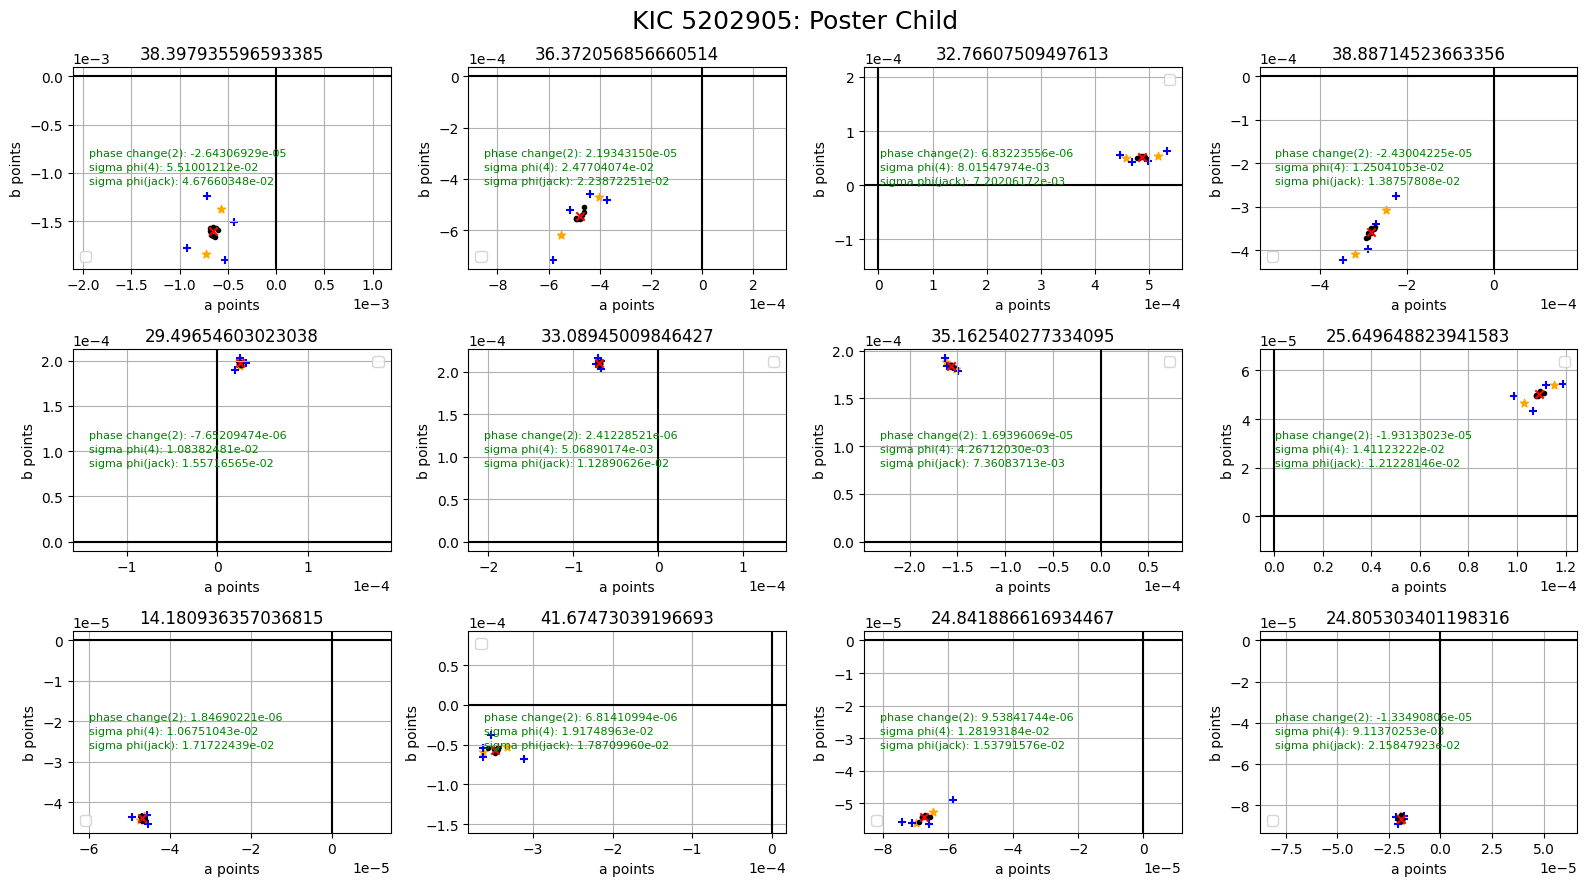

In [54]:
# three phase values: rate_of_phase, phase_change, sigma_phi4, sigma_phij
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

plt.suptitle("KIC 5202905: Poster Child", fontsize = 18)

for idx, (ax, points1, points2, points3, points4, p1, p2, p3) in enumerate(zip(axes.flat, all, half, quartiles, eighths, rate_of_phase, 
                                                                                   sigma_phi4, sigma_phij)):
    
    a_all = points1[0]  
    b_all = points1[1]  

    a_half = points2[:, 0]  
    b_half = points2[:, 1]  

    a_quarter = points3[:, 0]  
    b_quarter = points3[:, 1] 

    a_eighth = points4[:, 0]
    b_eighth= points4[:, 1]

    ax.scatter(a_half, b_half, color='orange', marker='*')
    ax.scatter(a_quarter, b_quarter, color='blue', marker='+')
    ax.scatter(a_eighth, b_eighth, color='k', marker='.')
    ax.scatter(a_all, b_all, color='red', marker='x')
    
    #phase labeling
    ax.text(0.05, 0.6, f"phase change(2): {p1:0.8e}" , transform=ax.transAxes, fontsize=8,
        verticalalignment='top', color='green')
    ax.text(0.05, 0.53, f"sigma phi(4): {p2:0.8e}", transform=ax.transAxes, fontsize=8,
        verticalalignment='top', color='green')
    ax.text(0.05, 0.46, f"sigma phi(jack): {p3:0.8e}", transform=ax.transAxes, fontsize=8,
        verticalalignment='top', color='green')
    
    
    
    ax.legend()
    ax.axvline(0, color = 'k')
    ax.axhline(0, color = 'k')
    ax.set_title(final_freqs520[idx])
    ax.set_xlabel("a points")
    ax.set_ylabel("b points")
    ax.grid(True)
    ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
    ax.axis('equal')



plt.tight_layout()


In [19]:
#2, 2, 4, 4, 8
amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij = sampling_stats(all, quartiles, eighths)


In [36]:
print(sigma_phi4)

[0.05510012 0.02477041 0.00801548 0.01250411 0.01083825 0.0050689
 0.00426712 0.01411232 0.0106751  0.0191749  0.01281932 0.0091137 ]


In [ ]:
p